# Clique Cover Problem
Here we show how to solve the clique cover problem using OpenJij, [JijModeling](https://www.ref.documentation.jijzept.com/jijmodeling/), and [JijModeling Transpiler](https://www.ref.documentation.jijzept.com/jijmodeling-transpiler/). This problem is also mentioned in 6.2. Clique Cover in [Lucas, 2014, "Ising formulations of many NP problems"](https://doi.org/10.3389/fphy.2014.00005).

## Overview of the Clique Cover Problem

The clique covering problem is to determine whether, given a graph and an integer $n$, the graph can be partitioned into $n$ cliques (complete graphs).

### Complete Graph

A complete graph is a graph whose two vertices are all adjacent to each other (not including loops or multiple edges).
We show two examples below.

![](../../../assets/clique_cover_01.png)

As mentioned, a vertex in a complete graph is adjacent to all other vertices. 
A complete undirected graph $G = (V, E)$ has ${}_V C_2 = \frac{1}{2} V(V-1)$ edges, which shows that the number of edges is equal to the number of combinations choosing two vertices from $V$.
Based on minimizing the difference in the number of edges from a complete graph, we describe a mathematical model for the clique cover problem.


### Binary Variable

We introduce a binary variable $x_{v, n}$ such that $x_{v, n}$ is 1 if the vertex $v$ belongs to the $n$th clique and 0 otherwise.

### Constraint
Each vertex can belong to only one clique, meaning that the graph is divided into $N$ cliques:

$$
\sum_{n=0}^{N-1} x_{v, n} = 1 \quad (\forall v \in V)
$$(1)

### Objective Function
Let us consider the $n$th subgraph $G (V_n, E_n)$.
The number of vertices is $V_n = \sum_v x_{v,n}$. 
If this subgraph is complete, the number of edges of this subgraph is $\frac{1}{2} V_n (V_n -1)$ from the previous discussion. 
The number of edges can actually be written as $\sum_{(uv) \in E_n} x_{u, n} x_{v, n}$.
The subgraph $G$ is neatly divided into cliques when the difference between these two approaches is zero.
Therefore, we set the objective function as follows:

$$
\mathbf{obj} 
= \sum_{n=0}^{N-1} \left\{ \frac{1}{2} \left( \sum_{v=0}^{V-1} x_{v, n} \right) \left( \sum_{v=0}^{V-1} x_{v, n} -1\right) - \sum_{(uv) \in E} x_{u, n} x_{v, n} \right\}
$$(2)

## Modeling by JijModeling

Next, we show an implementation using JijModeling.
We first define variables for the mathematical model described above.

### Variables

Let us define the variables used in expressions (1) and (2) as follows:

In [1]:
import jijmodeling as jm

# define variables
V = jm.Placeholder("V")
E = jm.Placeholder("E", ndim=2)
N = jm.Placeholder("N")
x = jm.BinaryVar("x", shape=(V, N))
n = jm.Element("n", (0, N))
v = jm.Element("v", (0, V))
e = jm.Element("e", E)

`V=jm.Placeholder('V')` defines the number of vertices in the graph and `E=jm.Placeholder('E', ndim=2)` defines the graph's edge set. `N=jm.Placeholder('N')` determines how many cliques the graph is divided into, and `V, N` is used to define the binary variable $x_{v, n}$ as `x=jm.Binary('x', shape=(V, N))`.
`n, v` is the variable used to index the binary variable, and `e` is the variable for the edge.
`e[0], e[1]` are the vertices located at both ends of edge `e`, which makes $(uv) = (e[0] e[1])$.

### Constraints and Objective Function

Let us implement the constraint in expression (1).

In [2]:
# set problem
problem = jm.Problem("Clique Cover")
# set one-hot constraint: each vertex has only one color
problem += jm.Constraint("color", x[v, :].sum() == 1, forall=v)
# set objective function: minimize the difference in the number of edges from complete graph
clique = x[:, n].sum() * (x[:, n].sum() - 1) / 2
num_e = jm.sum(e, x[e[0], n] * x[e[1], n])
problem += jm.sum(n, clique - num_e)

problem

With `clique`, we calculate the number of edges if the vertex had created a clique. The next `num_e` is the calculated number of edges that the vertex has. Finally, the sum of the differences is added as the objective function.

### Instance

Here we prepare a graph using [NetworkX](https://networkx.org/).

In [3]:
import networkx as nx

# set the number of colors
inst_N = 3
# set empty graph
inst_G = nx.Graph()
# add edges
inst_E = [[0, 1], [1, 2], [0, 2], 
            [3, 4], [4, 5], [5, 6], [3, 6], [3, 5], [4, 6], 
            [7, 8], [8, 9], [7, 9], 
            [1, 3], [2, 6], [5, 7], [5, 9]]
inst_G.add_edges_from(inst_E)
# get the number of nodes
inst_V = list(inst_G.nodes)
num_V = len(inst_V)
instance_data = {'N': inst_N, 'V': num_V, 'E': inst_E}

The graph set up by this instance is as follows.

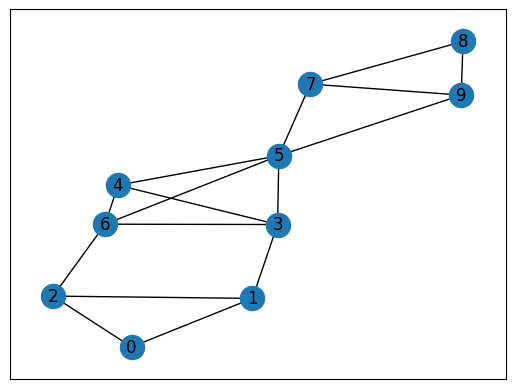

In [4]:
import matplotlib.pyplot as plt

nx.draw_networkx(inst_G, with_labels=True)
plt.show()

This graph consists of three cliques (0, 1, 2), (3, 4, 5, 6), and(7, 8, 9).

### Create OMMX-Instance with `jijmodeling.Interpreter`

In [5]:
instance = jm.Interpreter(instance_data).eval_problem(problem)

## Solve by OpenJij

In [6]:
import ommx_openjij_adapter as oj_ad

sampleset = oj_ad.OMMXOpenJijSAAdapter.sample(
    instance,
    num_reads=100,
    uniform_penalty_weight=1.1
)

## Check result and visualize

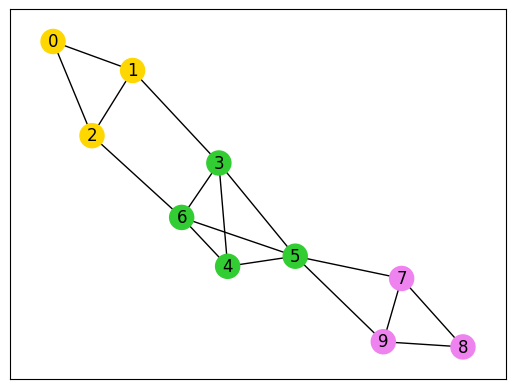

In [7]:
import numpy as np

best_sample = sampleset.best_feasible_unrelaxed()

x_value = best_sample.extract_decision_variables("x")
nonzero_indices = [k for k, v in x_value.items() if v > 0]

node_colors = [-1] * instance_data["V"]
cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in range(instance_data["N"])]
colorlist = ["gold", "violet", "limegreen"]
for i, j in nonzero_indices:
    node_colors[i] = colorlist[j]

fig = plt.figure()
nx.draw_networkx(inst_G, node_color=node_colors, with_labels=True)
plt.show()